# **Подготовка данных**

Для начала нам необходимо загрузить файлы в виде pandas DataFrame

In [ ]:
# Импорт модулей для работы с файлами в Google Colaboratory

from google.colab import files
import io
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
# Загрузка локальных файлов

uploaded = files.upload()

Saving large_twitch_edges.csv to large_twitch_edges.csv
Saving large_twitch_features.csv to large_twitch_features.csv


In [ ]:
# Импорт модуля pandas
import pandas as pd

# Чтение csv-файлов
target = pd.read_csv(io.BytesIO(uploaded['large_twitch_features.csv']))
edges = pd.read_csv(io.BytesIO(uploaded['large_twitch_edges.csv']))

Создадим функцию для рассчета характеристик параметров датасетов

In [ ]:
def scale_values(value):
    uniq_values = sorted(value.unique())
    shape_value = len(uniq_values)
    if value.dtype == object:
        min_value = "-"
        max_value = "-"
    else:
        min_value = pd.Series(uniq_values).min()
        max_value = pd.Series(uniq_values).max()

    return value.dtype, shape_value, min_value, max_value, uniq_values

## **Работа с узлами** *(large_twitch_features.csv)*

Посмотрим характеристики набора

In [ ]:
target.head()

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
0,7879,1,969,2016-02-16,2018-10-12,0,0,EN,1
1,500,0,2699,2011-05-19,2018-10-08,1,0,EN,0
2,382502,1,3149,2010-02-27,2018-10-12,2,0,EN,1
3,386,0,1344,2015-01-26,2018-10-01,3,0,EN,0
4,2486,0,1784,2013-11-22,2018-10-11,4,0,EN,0


In [ ]:
print('Количество записей: {}\nКоличество признаков: {}'.format(target.shape[0], target.shape[1]))

Количество записей: 1000
Количество признаков: 9


In [ ]:
scale_values_target = target.apply(scale_values).transpose()
scale_values_target.columns = ["type", "shape", "min", "max", "uniq_values"]
scale_values_target

,type,shape,min,max,uniq_values
views,int64,971,10,19959321,"[10, 14, 29, 34, 37, 41, 49, 59, 63, 64, 71, 7..."
mature,int64,2,0,1,"[0, 1]"
life_time,int64,811,174,4149,"[174, 180, 182, 184, 187, 191, 192, 204, 232, ..."
created_at,object,809,-,-,"[2007-05-22, 2007-07-13, 2007-10-07, 2008-06-3..."
updated_at,object,90,-,-,"[2017-01-24, 2017-10-05, 2017-10-16, 2018-01-0..."
numeric_id,int64,1000,0,999,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
dead_account,int64,2,0,1,"[0, 1]"
language,object,20,-,-,"[CS, DA, DE, EN, ES, FI, FR, HU, IT, JA, KO, N..."
affiliate,int64,2,0,1,"[0, 1]"


Удалим даты создания и изменения, а так же языки, так как эти параметры будет трудно закодировать с помощью OneHotEncoding, так как они имеют очень большое количество возможных значений

In [ ]:
target = target.drop(['created_at', 'updated_at', 'language'], axis=1)
target.head()

,views,mature,life_time,numeric_id,dead_account,affiliate
0,7879,1,969,0,0,1
1,500,0,2699,1,0,0
2,382502,1,3149,2,0,1
3,386,0,1344,3,0,0
4,2486,0,1784,4,0,0


## **Работа со связями** *(large_twitch_edges.csv)*

Посмотрим характеристики набора

In [ ]:
edges.head()

,numeric_id_1,numeric_id_2
0,495,116
1,373,916
2,373,429
3,373,142
4,373,472


In [ ]:
print('Количество записей: {}\nКоличество признаков: {}'.format(edges.shape[0], edges.shape[1]))

Количество записей: 257
Количество признаков: 2


In [ ]:
scale_values_edges = edges.apply(scale_values).transpose()
scale_values_edges.columns = ["type", "shape", "min", "max", "uniq_values"]
scale_values_edges

,type,shape,min,max,uniq_values
numeric_id_1,int64,108,1,998,"[1, 11, 22, 49, 50, 56, 60, 73, 76, 83, 85, 87..."
numeric_id_2,int64,200,1,988,"[1, 4, 7, 10, 17, 21, 31, 36, 40, 47, 50, 51, ..."


Исходя из описания данных, связи представляют собой подписки пользователей друг на друга, то есть - ребра неориентированного графа. Так как в дальнейшем эти данные будут использоваться в таблице направленных связей, создадим дубликат "обратных" связей и добавим их в данные

In [ ]:
reverse_edges = edges.rename(columns={"id_1": "id_2", "id_2": "id_1"})
reverse_edges.tail()

,numeric_id_1,numeric_id_2
252,675,394
253,883,835
254,841,512
255,727,931
256,746,768


Добавим полученные строки в конец DataFrame

In [ ]:
edges = pd.concat([edges, reverse_edges], ignore_index=True)
edges.head()

,numeric_id_1,numeric_id_2
0,495,116
1,373,916
2,373,429
3,373,142
4,373,472


In [ ]:
edges.tail()

,numeric_id_1,numeric_id_2
509,675,394
510,883,835
511,841,512
512,727,931
513,746,768


Начало таблицы осталось прежним, а окончание совпадает с последними строками reverse_edges.

Далее необходимо создать матрицу смежности в виде DataFrame, в котором строки содержат id пользователя-подписчика, id пользователя, на которого подписались, и значение 0/1 в зависимости от того, существует ли такая подписка или нет. Для этого добавим в DataFrame существующих связей колонку edge, заполнив ее единицами

In [ ]:
edges["edge"] = 1
edges

,numeric_id_1,numeric_id_2,edge
0,495,116,1
1,373,916,1
2,373,429,1
3,373,142,1
4,373,472,1
...,...,...,...
509,675,394,1
510,883,835,1
511,841,512,1
512,727,931,1


Создадим матрицу смежности в виде DataFrame из всех возможных пар пользователей

In [ ]:
adjacency = pd.DataFrame(target["numeric_id"])
adjacency = adjacency.merge(adjacency, how="cross")
adjacency

,numeric_id_x,numeric_id_y
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
999995,999,995
999996,999,996
999997,999,997
999998,999,998


И объединим новую таблицу с таблицей существующих связей, взяв от результата merge список всех пар id и связи

In [ ]:
adjacency = adjacency.merge(edges, how="left", left_on=["numeric_id_x", "numeric_id_y"], right_on=["numeric_id_1", "numeric_id_2"], copy=False)
adjacency = adjacency[['numeric_id_x', 'numeric_id_y', 'edge']]
adjacency

,numeric_id_x,numeric_id_y,edge
0,0,0,NaN
1,0,1,NaN
2,0,2,NaN
3,0,3,NaN
4,0,4,NaN
...,...,...,...
1000252,999,995,NaN
1000253,999,996,NaN
1000254,999,997,NaN
1000255,999,998,NaN


У пар, данных о которых не было в исходном файле связей, образовалось значение NaN. Его необходимо заменить на 0

In [ ]:
adjacency["edge"] = adjacency["edge"].fillna(0)
adjacency

,numeric_id_x,numeric_id_y,edge
0,0,0,0.0
1,0,1,0.0
2,0,2,0.0
3,0,3,0.0
4,0,4,0.0
...,...,...,...
1000252,999,995,0.0
1000253,999,996,0.0
1000254,999,997,0.0
1000255,999,998,0.0


Проверяем, что количество единиц в полученном DataFrame совпадает с числом существующих связей в edges

In [ ]:
adjacency["edge"].value_counts()[1] == edges.shape[0]

True

Проверяем, что все данные заполнены

In [ ]:
adjacency.isna().sum()

numeric_id_x    0
numeric_id_y    0
edge            0
dtype: int64

## **Объединение таблиц в один файл**

Объединим данные пользователей с таблицей связей для дальнейшего обучения

In [ ]:
df = adjacency.merge(target, how='left', left_on='numeric_id_x', right_on='numeric_id', copy=False)
df = df.drop('numeric_id', axis=1)
df = df.rename(columns={label:label+'_x' for label in target.columns})
df

,numeric_id_x,numeric_id_y,edge,views_x,mature_x,life_time_x,dead_account_x,affiliate_x
0,0,0,0.0,7879,1,969,0,1
1,0,1,0.0,7879,1,969,0,1
2,0,2,0.0,7879,1,969,0,1
3,0,3,0.0,7879,1,969,0,1
4,0,4,0.0,7879,1,969,0,1
...,...,...,...,...,...,...,...,...
1000252,999,995,0.0,618,0,1498,0,0
1000253,999,996,0.0,618,0,1498,0,0
1000254,999,997,0.0,618,0,1498,0,0
1000255,999,998,0.0,618,0,1498,0,0


In [ ]:
df = df.merge(target, how='left', left_on='numeric_id_y', right_on='numeric_id', copy=False)
df = df.drop('numeric_id', axis=1)
df = df.rename(columns={label:label+'_y' for label in target.columns})
df

,numeric_id_x,numeric_id_y,edge,views_x,mature_x,life_time_x,dead_account_x,affiliate_x,views_y,mature_y,life_time_y,dead_account_y,affiliate_y
0,0,0,0.0,7879,1,969,0,1,7879,1,969,0,1
1,0,1,0.0,7879,1,969,0,1,500,0,2699,0,0
2,0,2,0.0,7879,1,969,0,1,382502,1,3149,0,1
3,0,3,0.0,7879,1,969,0,1,386,0,1344,0,0
4,0,4,0.0,7879,1,969,0,1,2486,0,1784,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000252,999,995,0.0,618,0,1498,0,0,2579,1,2488,0,1
1000253,999,996,0.0,618,0,1498,0,0,1562,0,1443,0,0
1000254,999,997,0.0,618,0,1498,0,0,8438,1,2965,0,0
1000255,999,998,0.0,618,0,1498,0,0,3916,1,1611,0,1


Проверяем, что все данные заполнены

In [ ]:
df.isna().sum()

numeric_id_x      0
numeric_id_y      0
edge              0
views_x           0
mature_x          0
life_time_x       0
dead_account_x    0
affiliate_x       0
views_y           0
mature_y          0
life_time_y       0
dead_account_y    0
affiliate_y       0
dtype: int64

Посмотрим характеристики набора

In [ ]:
print('Количество записей: {}\nКоличество признаков: {}'.format(df.shape[0], df.shape[1]))

Количество записей: 1000257
Количество признаков: 13


In [ ]:
scale_values_df = df.apply(scale_values).transpose()
scale_values_df.columns = ["type", "shape", "min", "max", "uniq_values"]
scale_values_df

,type,shape,min,max,uniq_values
numeric_id_x,int64,1000,0,999,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
numeric_id_y,int64,1000,0,999,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
edge,float64,2,0.0,1.0,"[0.0, 1.0]"
views_x,int64,971,10,19959321,"[10, 14, 29, 34, 37, 41, 49, 59, 63, 64, 71, 7..."
mature_x,int64,2,0,1,"[0, 1]"
life_time_x,int64,811,174,4149,"[174, 180, 182, 184, 187, 191, 192, 204, 232, ..."
dead_account_x,int64,2,0,1,"[0, 1]"
affiliate_x,int64,2,0,1,"[0, 1]"
views_y,int64,971,10,19959321,"[10, 14, 29, 34, 37, 41, 49, 59, 63, 64, 71, 7..."
mature_y,int64,2,0,1,"[0, 1]"


Исправим тип данных у "edge"

In [ ]:
df["edge"] = df["edge"].astype('int64')

In [ ]:
scale_values_df = df.apply(scale_values).transpose()
scale_values_df.columns = ["type", "shape", "min", "max", "uniq_values"]
scale_values_df

,type,shape,min,max,uniq_values
numeric_id_x,int64,1000,0,999,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
numeric_id_y,int64,1000,0,999,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
edge,int64,2,0,1,"[0, 1]"
views_x,int64,971,10,19959321,"[10, 14, 29, 34, 37, 41, 49, 59, 63, 64, 71, 7..."
mature_x,int64,2,0,1,"[0, 1]"
life_time_x,int64,811,174,4149,"[174, 180, 182, 184, 187, 191, 192, 204, 232, ..."
dead_account_x,int64,2,0,1,"[0, 1]"
affiliate_x,int64,2,0,1,"[0, 1]"
views_y,int64,971,10,19959321,"[10, 14, 29, 34, 37, 41, 49, 59, 63, 64, 71, 7..."
mature_y,int64,2,0,1,"[0, 1]"


Сохраним полученный датасет на диск

In [ ]:
df.to_csv('/content/drive/My Drive/Colab Notebooks/ml_social_graphs/data.csv')

## **Машинное обучение**

Разделение данных на тестовую и обучающую выборки

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

y = df.edge
X = df.drop(['numeric_id_x', 'numeric_id_y', 'edge'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Добавим функцию для отрисовки матриц

In [ ]:
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def matrix_drow(y_test, y_pred):
  class_names = [0, 1]
  fig, ax = plt.subplots()
  ticks = np.arange(len(class_names))
  plt.xticks(ticks, class_names)
  plt.yticks(ticks, class_names)

  sns.heatmap(pd.DataFrame(
      metrics.confusion_matrix(y_test, y_pred)),
      annot=True)
  plt.ylabel('Действительные значения')
  plt.xlabel('Предсказанные значения')

### **Построение моделей**

#### Логистическая регрессия

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299924
           1       0.25      0.01      0.02       154

    accuracy                           1.00    300078
   macro avg       0.62      0.51      0.51    300078
weighted avg       1.00      1.00      1.00    300078



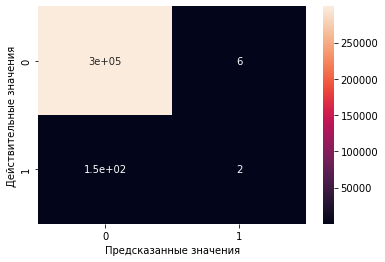

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

Модель имеет большой дисбаланс классов, так как имеющихся связей в графе очевидно меньше, чем всех возможных. Для того, чтобы сгладить этот дисбаланс можно найти порог попадания в каждый класс

Вычисляем оптимальную J-статистику Юдена для установления порога попадания в каждый класс

In [ ]:
from numpy import argmax

yhat = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.000059


              precision    recall  f1-score   support

           0       1.00      0.59      0.74    299924
           1       0.00      0.47      0.00       154

    accuracy                           0.59    300078
   macro avg       0.50      0.53      0.37    300078
weighted avg       1.00      0.59      0.74    300078



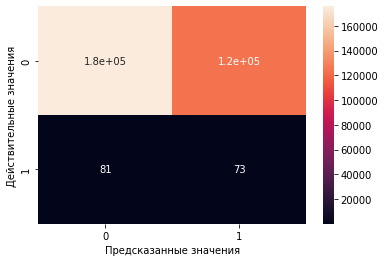

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test)[:,1] >= best_thresh).astype(bool)

print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

Еще один более простой способ, который можно применить к большему числу моделей - установить веса для каждого класса, согласно пропорции колличества экземпляров в каждом классе

In [ ]:
weight_0 = round(154/299924, 5)
weight_1 = round(1 - weight_0, 5)
(weight_0, weight_1)

(0.00051, 0.99949)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    299924
           1       0.00      0.50      0.01       154

    accuracy                           0.94    300078
   macro avg       0.50      0.72      0.49    300078
weighted avg       1.00      0.94      0.97    300078



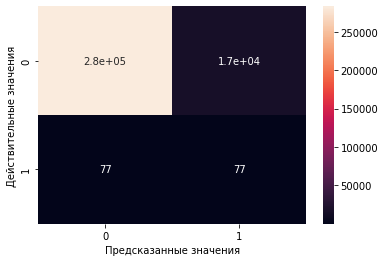

In [ ]:
model = LogisticRegression(class_weight={0: weight_0, 1:weight_1})
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

#### Метод стохастического градиентного спуска

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299924
           1       0.00      0.00      0.00       154

    accuracy                           1.00    300078
   macro avg       0.50      0.50      0.50    300078
weighted avg       1.00      1.00      1.00    300078



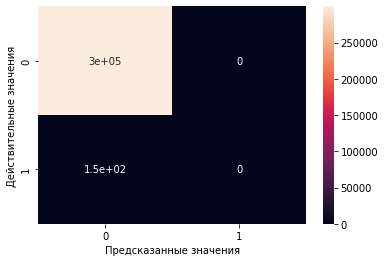

In [ ]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

In [ ]:
weight_0, weight_1

(0.00051, 0.99949)

              precision    recall  f1-score   support

           0       1.00      0.37      0.54    299924
           1       0.00      0.94      0.00       154

    accuracy                           0.37    300078
   macro avg       0.50      0.66      0.27    300078
weighted avg       1.00      0.37      0.54    300078



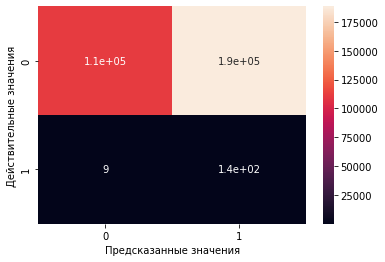

In [ ]:
model = SGDClassifier(class_weight={0: weight_0, 1:weight_1})
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

#### Метод опорных векторов наименьших квадратов

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299924
           1       0.00      0.00      0.00       154

    accuracy                           1.00    300078
   macro avg       0.50      0.50      0.50    300078
weighted avg       1.00      1.00      1.00    300078



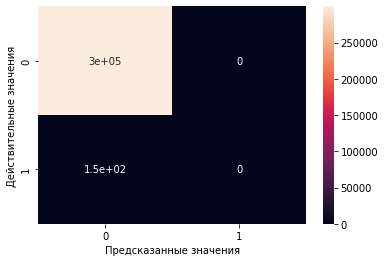

In [ ]:
from sklearn.linear_model import RidgeClassifier

model = RidgeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89    299924
           1       0.00      0.45      0.00       154

    accuracy                           0.80    300078
   macro avg       0.50      0.63      0.45    300078
weighted avg       1.00      0.80      0.89    300078



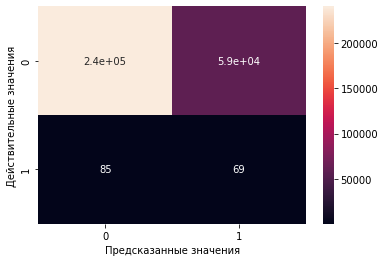

In [ ]:
model = RidgeClassifier(class_weight={0: weight_0, 1:weight_1})
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299924
           1       0.00      0.00      0.00       154

    accuracy                           1.00    300078
   macro avg       0.50      0.50      0.50    300078
weighted avg       1.00      1.00      1.00    300078



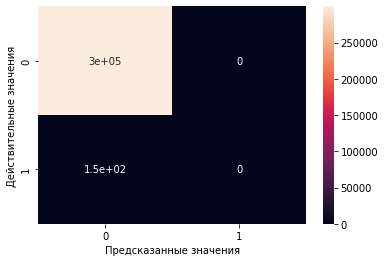

In [ ]:
from sklearn.linear_model import RidgeClassifierCV

model = RidgeClassifierCV()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    299924
           1       0.01      0.38      0.02       154

    accuracy                           0.98    300078
   macro avg       0.50      0.68      0.51    300078
weighted avg       1.00      0.98      0.99    300078



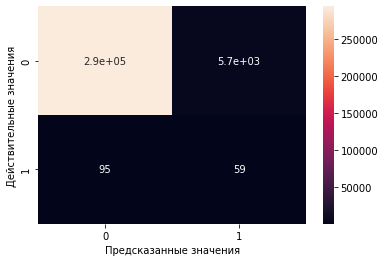

In [ ]:
model = RidgeClassifierCV(class_weight={0: weight_0, 1:weight_1})
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

#### Пассивно-агрессивный классификатор

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299924
           1       0.01      0.05      0.02       154

    accuracy                           1.00    300078
   macro avg       0.51      0.52      0.51    300078
weighted avg       1.00      1.00      1.00    300078



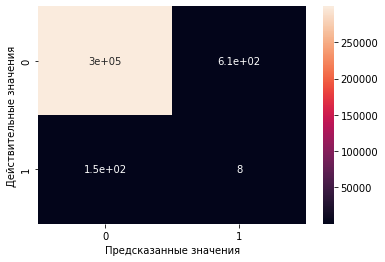

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

model = PassiveAggressiveClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.63      0.77    299924
           1       0.00      0.88      0.00       154

    accuracy                           0.63    300078
   macro avg       0.50      0.75      0.39    300078
weighted avg       1.00      0.63      0.77    300078



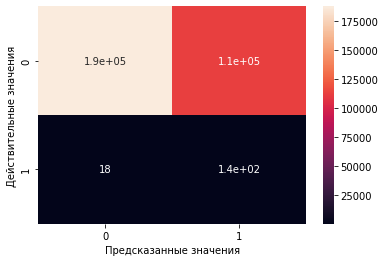

In [ ]:
model = PassiveAggressiveClassifier(class_weight={0: weight_0, 1:weight_1})
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

#### Наивные методы Байеса

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    299924
           1       0.01      0.23      0.02       154

    accuracy                           0.99    300078
   macro avg       0.50      0.61      0.51    300078
weighted avg       1.00      0.99      0.99    300078



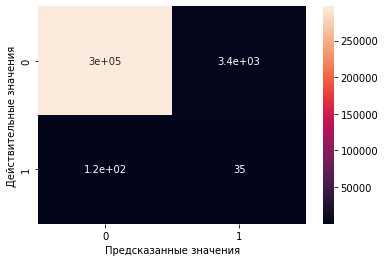

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    299924
           1       0.00      0.71      0.00       154

    accuracy                           0.81    300078
   macro avg       0.50      0.76      0.45    300078
weighted avg       1.00      0.81      0.89    300078



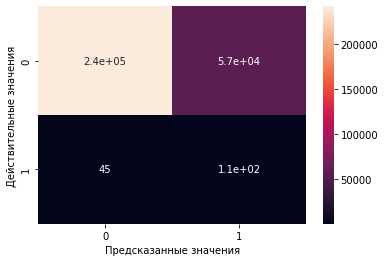

In [ ]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    299924
           1       0.00      0.71      0.00       154

    accuracy                           0.81    300078
   macro avg       0.50      0.76      0.45    300078
weighted avg       1.00      0.81      0.89    300078



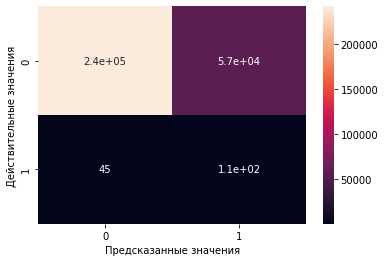

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
matrix_drow(y_test, y_pred)